In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-04-27 16:18:30.995099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 16:18:31.549558: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/
2023-04-27 16:18:31.550033: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/

In [2]:
dim = 32*32
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    inputs = inputs
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(dim, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return tf.keras.Model(inputs,x)

input_shape = image_size + (1,)
embedding = classifier(tf.keras.layers.Input(input_shape))

2023-04-27 16:18:32.266128: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 16:18:32.266342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 16:18:32.271556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 16:18:32.271773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 16:18:32.271951: I tensorflow/compiler/xla/stream_executo

In [3]:
embedding.load_weights('../../23_jan/border/checkpoints/embedding')
for layer in embedding.layers:
    layer.trainable = False
embedding.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 64)  256         ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 64)   2112        ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 16, 16, 64)   0           ['max_pooling2d_2[0][0]',        
          

In [61]:
class function_type:
    def splines(y,num_classes,order):


        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        #a = tf.keras.layers.Dense(num_classes*order,activation = 'relu')(y)
        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)

        a = tf.keras.layers.Reshape((num_classes,order))(a)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)

        return a,b

    def decreasing(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)
        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        a = tf.keras.layers.Lambda(lambda z:-tf.math.pow(z,2))(a)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)

        return a,b

    def flux(y,num_classes,order):
        b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
        b_initial = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_initial)

        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        s0 = tf.keras.layers.Dense(1,activation='sigmoid')(y)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s0))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_initial))
        b = tf.expand_dims(b,axis=-1)


        minimum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s0,minimum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s0,a))
        fun = tf.keras.layers.add((coeffs,fun))
        minimum = tf.keras.layers.Lambda(lambda z:-tf.reduce_min(z[...,0],axis=-1))(fun)
        minimum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.less_equal(-z,0),dtype=tf.float32))(minimum)
        minimum = tf.keras.layers.multiply((minimum,minimum_neg))

        b = tf.keras.layers.add((b,minimum))

        a_pos,b_pos = a,b

        b_middle = tf.keras.layers.Dense(1,activation='linear')(y)
        b_middle = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(b_middle)


        a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
        a = tf.keras.layers.Reshape((num_classes,order))(a)
        s1 = tf.keras.layers.Lambda(lambda z: tf.ones_like(z)-z)(s0)

        b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
        b = tf.keras.layers.multiply((b,s1))
        b = tf.pow(b,np.arange(1,order+1))
        b = tf.keras.layers.multiply([a,b])

        m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
        b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
        b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
        b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
        b = tf.keras.layers.Concatenate(axis=1)([b0,b])
        b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
        b = tf.keras.layers.add((b,b_middle))
        b = tf.expand_dims(b,axis=-1)


        maximum = tf.ones_like(a)/(num_classes)
        fun = tf.keras.layers.multiply((s1,maximum,a))
        fun = tf.keras.layers.add((fun,b))
        coeffs = 2*(tf.cumsum(tf.ones_like(a)/(num_classes),axis=1))
        coeffs = tf.keras.layers.multiply((coeffs,s1))
        coeffs = tf.keras.layers.add((coeffs,s0))
        coeffs = tf.keras.layers.multiply((a,coeffs))
        fun = tf.keras.layers.add((coeffs,fun))
        maximum = tf.keras.layers.Lambda(lambda z:-tf.reduce_max(z[...,0],axis=-1))(fun)
        maximum_neg = tf.keras.layers.Lambda(lambda z: tf.cast(tf.greater_equal(-z,0),dtype=tf.float32))(maximum)
        maximum = tf.keras.layers.multiply((maximum,maximum_neg))
        maximum = tf.keras.layers.Lambda(lambda z:tf.expand_dims(z,axis=-1))(maximum)

        b = tf.keras.layers.add((b,maximum))

        a_neg,b_neg = a,b

        a = tf.keras.layers.Concatenate(axis=1)((a_pos,a_neg))
        b = tf.keras.layers.Concatenate(axis=1)((b_pos,b_neg))

        return a,b

In [62]:
input_shape = image_size + (1,)   
order = 1
it_lim = 1
gamma = 1
num_classes = 5
arch = 'splines'


inputs = tf.keras.Input(shape=input_shape,name='input')
x = embedding(inputs)
y = tf.keras.layers.Flatten(name='y')(x)
b_initial = tf.keras.layers.Dense(1,activation='linear')(y)
b_initial = tf.keras.layers.Lambda(lambda z: tf.zeros_like(z))(b_initial)


a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
a =  tf.keras.layers.Lambda(lambda z: tf.ones_like(z))(a)

a = tf.keras.layers.Reshape((num_classes,order))(a)

b = tf.keras.layers.Lambda(lambda z:tf.multiply(np.asarray(1/num_classes,dtype=np.float32),tf.ones_like(z)))(a)
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)  
b = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.ones_like(z[0]),z[1]))([a,b])
if arch == 'flux':
    num_classes = 2*num_classes


partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)


ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = inputs


for num_it in range(it_lim):


   
    dS_n,dE_n = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
    dS = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dS_n)
    dE = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dE_n)
    diff_op = tf.keras.layers.add((dS,dE))



    ineq1 = tf.greater_equal(diff_op, partition_low)
    ineq2 = tf.less_equal(diff_op,partition_up)

    interval = tf.cast(tf.math.logical_and(ineq1,ineq2),tf.float32)

    power_norm = tf.constant(np.asarray(np.arange(1,order+1),dtype='float32'))
    power_norm = tf.keras.layers.Lambda(lambda z:tf.pow(z[0],z[1]))([diff_op,power_norm])
    cte = tf.ones_like(inputs)
    power_norm = tf.keras.layers.Concatenate(axis=-1)((cte,power_norm))
    power_norm = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm)

    spline = tf.keras.layers.multiply([ct,power_norm])
    spline = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline)
    spline = tf.keras.layers.multiply([spline,interval])

    g = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'g_{num_it}')(spline)
    g = tf.expand_dims(g,axis=-1)


    deltaS,deltaE = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
    E = tf.keras.layers.multiply((g,deltaE))
    S = tf.keras.layers.multiply((g,deltaS))

    NS = S
    EW = E
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: z[:,1:] - z[:,:-1])(NS)
    EW = tf.keras.layers.Lambda(lambda z: z[:,:,1:] - z[:,:,:-1])(EW)

    mult = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.cast(gamma,dtype=tf.float32),z))(tf.ones_like(NS))

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])
    
target = tf.keras.models.Model(inputs, outputs)
for layer in target.layers:
    layer.trainable = False

In [63]:
input_shape = image_size + (1,)   
order = 1
it_lim = 1
gamma = 1


inputs = tf.keras.Input(shape=input_shape,name='input')
x = embedding(inputs)
y = tf.keras.layers.Flatten(name='y')(x)
a,b = getattr(function_type,arch)(y,num_classes,order)    
b = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.ones_like(z[0]),z[1]))([a,b])
if arch == 'flux':
    num_classes = 2*num_classes


partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)


ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = inputs


for num_it in range(it_lim):


   
    dS_n,dE_n = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
    dS = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dS_n)
    dE = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(dE_n)
    diff_op = tf.keras.layers.add((dS,dE))



    ineq1 = tf.greater_equal(diff_op, partition_low)
    ineq2 = tf.less_equal(diff_op,partition_up)

    interval = tf.cast(tf.math.logical_and(ineq1,ineq2),tf.float32)

    power_norm = tf.constant(np.asarray(np.arange(1,order+1),dtype='float32'))
    power_norm = tf.keras.layers.Lambda(lambda z:tf.pow(z[0],z[1]))([diff_op,power_norm])
    cte = tf.ones_like(inputs)
    power_norm = tf.keras.layers.Concatenate(axis=-1)((cte,power_norm))
    power_norm = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm)

    spline = tf.keras.layers.multiply([ct,power_norm])
    spline = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline)
    spline = tf.keras.layers.multiply([spline,interval])

    g = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'g_{num_it}')(spline)
    g = tf.expand_dims(g,axis=-1)


    deltaS,deltaE = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)
    E = tf.keras.layers.multiply((g,deltaE))
    S = tf.keras.layers.multiply((g,deltaS))

    NS = S
    EW = E
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: z[:,1:] - z[:,:-1])(NS)
    EW = tf.keras.layers.Lambda(lambda z: z[:,:,1:] - z[:,:,:-1])(EW)

    mult = tf.keras.layers.Lambda(lambda z: tf.multiply(tf.cast(gamma,dtype=tf.float32),z))(tf.ones_like(NS))

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])
    
model = tf.keras.models.Model(inputs, outputs)

In [64]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            if train_var:
                var = np.random.choice([10,20,50])
            else:
                #var = abs(var_u - np.random.exponential(var_d))
                var = np.random.uniform(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            continue        
            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            x = np.expand_dims(x,axis=-1)
            y = np.expand_dims(y,axis=-1)
            if y.shape != (CROP,CROP,1):
                continue
                
            y = target(np.array([y]))[0]
            
            if y.shape != (CROP,CROP,1):
                continue

            yield x,y
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [65]:
BATCH_SIZE = 50
train_var = False
var_d=5
var_u=60
pre = False
same = False

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

In [66]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

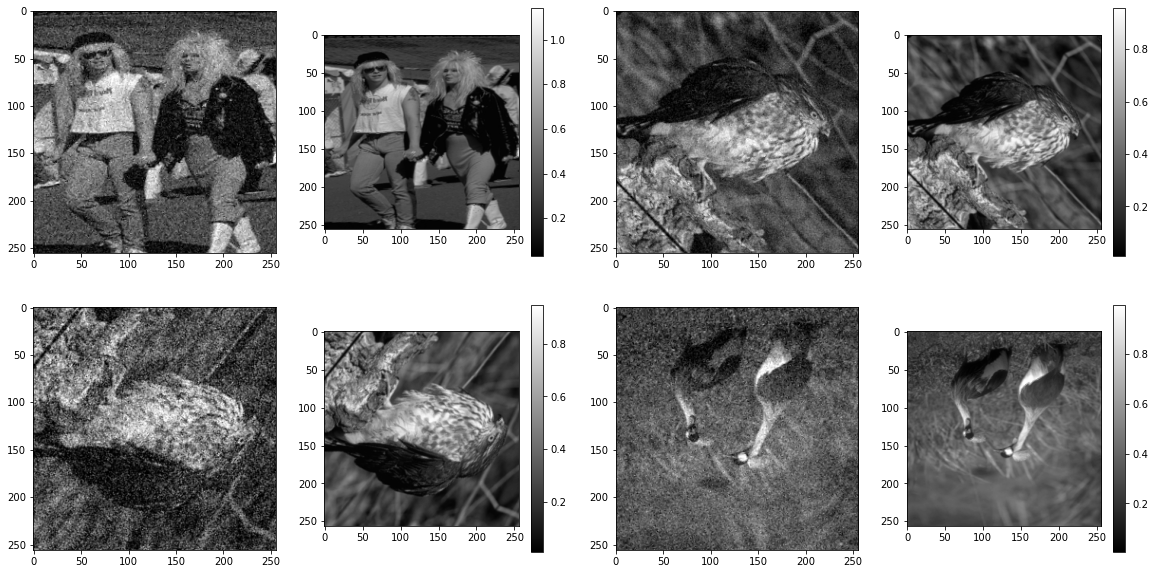

In [67]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        im = axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        plt.colorbar(im,ax=axs[i,2*j+1])
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

In [68]:
model.compile(optimizer='adam', loss='mse')
callbacks = [tf.keras.callbacks.ModelCheckpoint(
            filepath= f"./checkpoints/fitting_pline",
            save_weights_only=True,
            verbose = True,
            save_best_only=True),
                        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                        tf.keras.callbacks.TerminateOnNaN()

            ]

history = model.fit(
    gen_batch_train,
    epochs=10,
    steps_per_epoch=100,
    validation_data=gen_batch_val,
    validation_steps=10,
    shuffle=False,
    use_multiprocessing=True,
    callbacks=callbacks,
    workers=1
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.0057
Epoch 1: val_loss improved from inf to 0.00427, saving model to ./checkpoints/fitting_pline
100/100 [==============================] - 197s 2s/step - loss: 0.0057 - val_loss: 0.0043 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0043
Epoch 2: val_loss improved from 0.00427 to 0.00401, saving model to ./checkpoints/fitting_pline
100/100 [==============================] - 193s 2s/step - loss: 0.0043 - val_loss: 0.0040 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0040
Epoch 3: val_loss improved from 0.00401 to 0.00384, saving model to ./checkpoints/fitting_pline
100/100 [==============================] - 194s 2s/step - loss: 0.0040 - val_loss: 0.0038 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.0040
Epoch 4: val_loss improved from 0.00384 to 0.00383, saving model to ./checkpoints/fitting_pline
100

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  InvalidArgumentError: Exception encountered when calling layer 'lambda_1011' (type Lambda).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,256,255,1] vs. shape[1] = [1,256,1,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'lambda_1011' (type Lambda):
  • inputs=tf.Tensor(shape=(1, 256, 256, 1), dtype=float32)
  • mask=None
  • training=None
Traceback (most recent call last):

  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_3028887/1155964974.py", line 52, in get_data
    y = target(np.array([y]))[0]

  File "/home/joel/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/tmp/ipykernel_3028887/2504432681.py", line 56, in <lambda>
    dS_n,dE_n = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)

tensorflow.python.framework.errors_impl.InvalidArgumentError: Exception encountered when calling layer 'lambda_1011' (type Lambda).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,256,255,1] vs. shape[1] = [1,256,1,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'lambda_1011' (type Lambda):
  • inputs=tf.Tensor(shape=(1, 256, 256, 1), dtype=float32)
  • mask=None
  • training=None


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[Shape/_6]]
  (1) UNKNOWN:  InvalidArgumentError: Exception encountered when calling layer 'lambda_1011' (type Lambda).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,256,255,1] vs. shape[1] = [1,256,1,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'lambda_1011' (type Lambda):
  • inputs=tf.Tensor(shape=(1, 256, 256, 1), dtype=float32)
  • mask=None
  • training=None
Traceback (most recent call last):

  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/joel/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/tmp/ipykernel_3028887/1155964974.py", line 52, in get_data
    y = target(np.array([y]))[0]

  File "/home/joel/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/tmp/ipykernel_3028887/2504432681.py", line 56, in <lambda>
    dS_n,dE_n = tf.keras.layers.Lambda(lambda z: tf.image.image_gradients(z))(outputs)

tensorflow.python.framework.errors_impl.InvalidArgumentError: Exception encountered when calling layer 'lambda_1011' (type Lambda).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [1,256,255,1] vs. shape[1] = [1,256,1,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'lambda_1011' (type Lambda):
  • inputs=tf.Tensor(shape=(1, 256, 256, 1), dtype=float32)
  • mask=None
  • training=None


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_109210414]

In [ ]:
history = model.fit(
    gen_batch_train,
    epochs=10,
    steps_per_epoch=100,
    validation_data=gen_batch_val,
    validation_steps=10,
    shuffle=False,
    use_multiprocessing=True,
    callbacks=callbacks,
    workers=1
)

In [69]:
test_model = tf.keras.Model(model.input,model.get_layer('coeff_spline').output)

In [70]:
np.mean(np.abs(test_model(xs)[...,1]))

0.06331174

In [71]:
np.mean(test_model(xs)[...,0])

0.20643112

In [73]:
test_model(xs)[...,0]

<tf.Tensor: shape=(50, 5), dtype=float32, numpy=
array([[0.22623836, 0.23430875, 0.24182686, 0.23578209, 0.22211064],
       [0.17361005, 0.19291456, 0.18876529, 0.18699025, 0.1814612 ],
       [0.18378273, 0.22312564, 0.2168667 , 0.22039543, 0.23128411],
       [0.22823802, 0.23819013, 0.23845677, 0.23353146, 0.22471225],
       [0.19839288, 0.19867109, 0.20845795, 0.21320838, 0.22120991],
       [0.20610887, 0.18618678, 0.20345035, 0.2030189 , 0.21404094],
       [0.1876168 , 0.22475997, 0.22423996, 0.22019935, 0.20702553],
       [0.18241324, 0.21851273, 0.21365505, 0.2019206 , 0.18296516],
       [0.16504504, 0.21580072, 0.1804871 , 0.17253491, 0.15918387],
       [0.21585812, 0.20291233, 0.23282743, 0.23711962, 0.22350027],
       [0.18718444, 0.23133826, 0.22772656, 0.22373995, 0.21234462],
       [0.17283861, 0.21582513, 0.20777941, 0.20451322, 0.18794338],
       [0.20367858, 0.21547231, 0.21782905, 0.22439376, 0.22809817],
       [0.2185725 , 0.19618565, 0.2019172 , 0.2003232 